In [48]:
# import related librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, plot_confusion_matrix

In [49]:
# import dataset
df = pd.read_csv('mall_data/Mall_Customers.csv', index_col='CustomerID')

In [50]:
df.sample(10)

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
98,Female,27,60,50
71,Male,70,49,55
64,Female,54,47,59
195,Female,47,120,16
3,Female,20,16,6
181,Female,37,97,32
156,Female,27,78,89
138,Male,32,73,73
24,Male,31,25,73


In [51]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [52]:
df.shape

(200, 4)

In [53]:
# for i in df.columns:
#     print(i)
    #print(df[i].insnull().sum())
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Text(0, 0.5, 'Spending Score')

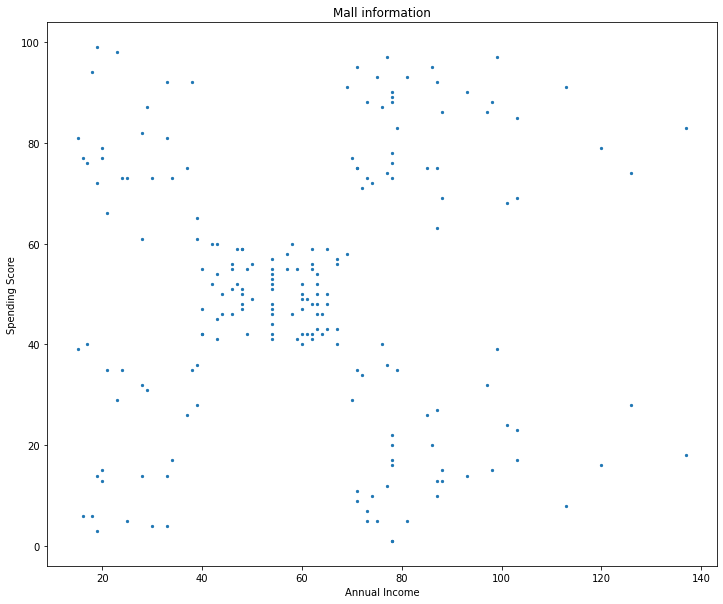

In [54]:
# plotting cluster
fig = plt.figure(figsize=(12,10))
plt.scatter( df['Annual Income (k$)'], df['Spending Score (1-100)'], s=5)
plt.title("Mall information")
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')


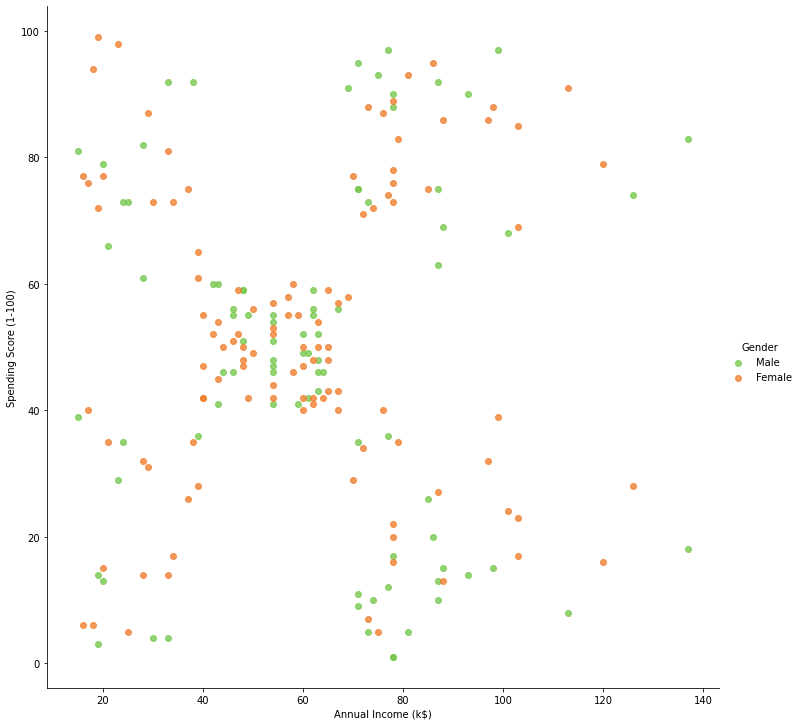

In [55]:
# define colors
type_colors = ['#78C850',  # Male
                       '#F08030',  # Female
                   ]

# plot data with the type color palette
sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)',  height=10, data=df,
           fit_reg=False, # No regression line
           hue='Gender', palette= pokemon_type_colors)

In [56]:
from sklearn.cluster import KMeans

# number of Pokémon clusters
team_size = 5

# make new dataframe with relevant metrics
_metrics = df['Annual Income (k$)'].to_frame().join(df['Spending Score (1-100)'].to_frame())

# z-score normalisation
_metrics_normalized=(_metrics-_metrics.mean())/_metrics.std()
_metrics_normalized = _metrics_normalized.rename(columns={'Annual Income (k$)': 'AnnualIncome_zscore', 'Spending Score (1-100)':'SpendingScore_zscore'})

# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=team_size, init='k-means++').fit(_metrics_normalized)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
_metrics_normalized = _metrics_normalized.join(cluster_labels.to_frame())

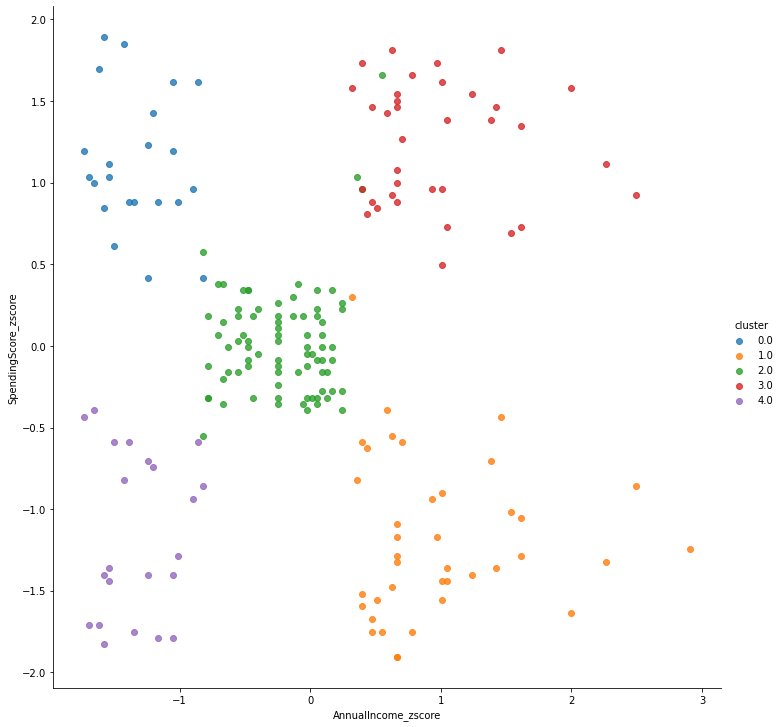

In [57]:
sns.lmplot(x='AnnualIncome_zscore', y='SpendingScore_zscore',  height=10, data=_metrics_normalized,
           fit_reg=False, hue='cluster')

In [64]:
_metrics_normalized[_metrics_normalized['cluster'].isna()]

,AnnualIncome_zscore,SpendingScore_zscore,cluster
CustomerID,,,
200,2.910368,1.27016,NaN


In [68]:
_metrics_normalized.dropna(axis=0, inplace=True)

In [71]:
# distance of every member to the other cluster
def distance_to_other_clusters(df):
    if not df.loc[df.isin(['AnnualIncome_zscore', 'SpendingScore_zscore', 'cluster'])].all():
        return
    metric = np.array([df['AnnualIncome_zscore'], df['SpendingScore_zscore']])
    cluster_number = round(df['cluster'])
    distance = 0
    for cluster_index in range(0, len(cluster_centers)):
        if cluster_index == cluster_number:
            continue
        center = cluster_centers[cluster_index]
        distance += np.sqrt(sum(np.square(metric - center)))
    return distance

# evaluate all Pokémon
_dissimilarity = _metrics_normalized.apply(distance_to_other_clusters, axis=1)
_dissimilarity = _dissimilarity.rename('dissimilarity')

# join to other metrics
_processed = _metrics_normalized.join(_dissimilarity.to_frame()).join(df['Gender'].to_frame())

# pick most dissimilar Pokémon per cluster
chosen_ = pd.DataFrame()
for cluster_index in range(0, len(cluster_centers)):
    _cluster = _processed[_processed['cluster'] == cluster_index]
    chosen_ = chosen_.append(_cluster[_cluster['dissimilarity']==_cluster['dissimilarity'].max()])


In [72]:
chosen_

,AnnualIncome_zscore,SpendingScore_zscore,cluster,dissimilarity,Gender
CustomerID,,,,,
12,-1.582351,1.889750,0.0,9.940745,Female
199,2.910368,-1.246925,1.0,14.273598,Male
142,0.549787,1.657404,2.0,8.889800,Male
198,2.491555,0.921640,3.0,12.529251,Male
3,-1.696572,-1.711618,4.0,9.722071,Female
